In [55]:
import os
import pandas as pd
import random
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import nltk

# Define the root folder where all data sources are located
jocas_dir = "/Users/alfonso/Desktop/JOCAS"  # Update this path if needed

# ===============================
# INITIALIZE CONTAINER
# ===============================
jocas_list = []

# ===============================
# INITIALIZE CONTAINER
# ===============================
jocas_list = []

# ===============================
# WALK THROUGH SOURCE FOLDERS
# ===============================
for source_folder in os.listdir(jocas_dir):
    source_path = os.path.join(jocas_dir, source_folder)
    
    if os.path.isdir(source_path):
        # ===============================
        # COLLECT ALL CSV FILES UNDER THIS SOURCE
        # ===============================
        csv_files = []
        
        # Walk through all subdirectories (e.g., "January", "December", etc.)
        for root, dirs, files in os.walk(source_path):
            for file in files:
                # Case-insensitive check for .csv files
                if file.lower().endswith('.csv'):
                    csv_files.append(os.path.join(root, file))
        
        print(f"Found {len(csv_files)} CSV files in source folder: {source_folder}")
        
        if not csv_files:
            continue
        
        # ===============================
        # SELECT UP TO 10 CSV FILES FROM THE SOURCE
        # ===============================
        if len(csv_files) > 10:
            selected_files = random.sample(csv_files, 10)
        else:
            selected_files = csv_files
        
        print(f"Processing {len(selected_files)} files from source folder: {source_folder}")
        
        # Process each selected CSV file
        for file_path in selected_files:
            try:
                df = pd.read_csv(
                    file_path,
                    header=0,
                    sep=';',
                    on_bad_lines='skip',
                    low_memory=False,
                    quoting=csv.QUOTE_MINIMAL,
                    escapechar='\\'
                )
                jocas_list.append(df)
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")

        print(f"Finished processing source folder: {source_folder}")

# ===============================
# AGGREGATE ALL DATAFRAMES INTO ONE
# ===============================
if jocas_list:
    final_df = pd.concat(jocas_list, ignore_index=True)
else:
    final_df = pd.DataFrame()


Found 361 CSV files in source folder: regionsjob_nord
Processing 10 files from source folder: regionsjob_nord
Finished processing source folder: regionsjob_nord
Found 357 CSV files in source folder: regionsjob_paris
Processing 10 files from source folder: regionsjob_paris
Finished processing source folder: regionsjob_paris
Found 359 CSV files in source folder: regionsjob_rhonealpes
Processing 10 files from source folder: regionsjob_rhonealpes
Finished processing source folder: regionsjob_rhonealpes
Found 362 CSV files in source folder: apec
Processing 10 files from source folder: apec
Finished processing source folder: apec
Found 169 CSV files in source folder: keljob
Processing 10 files from source folder: keljob
Finished processing source folder: keljob
Found 360 CSV files in source folder: regionsjob_sudouest
Processing 10 files from source folder: regionsjob_sudouest
Finished processing source folder: regionsjob_sudouest
Found 361 CSV files in source folder: regionsjob_paca
Process

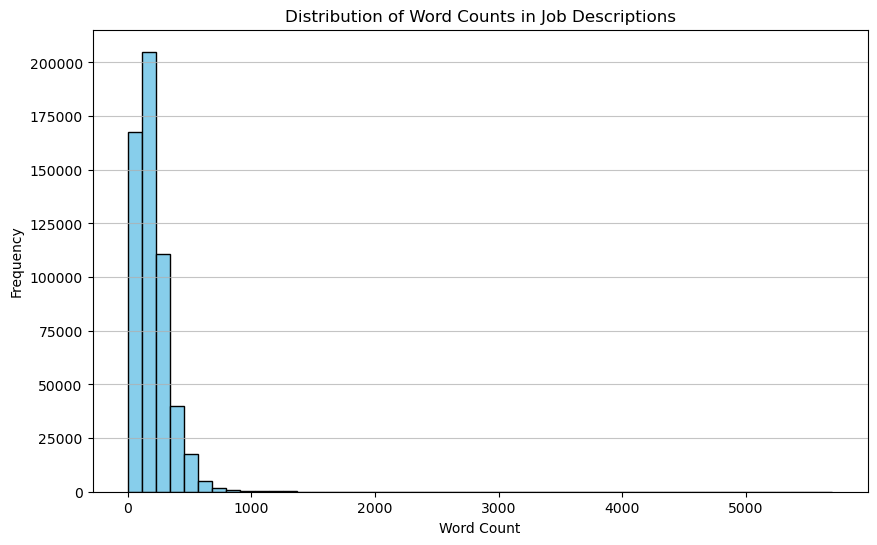

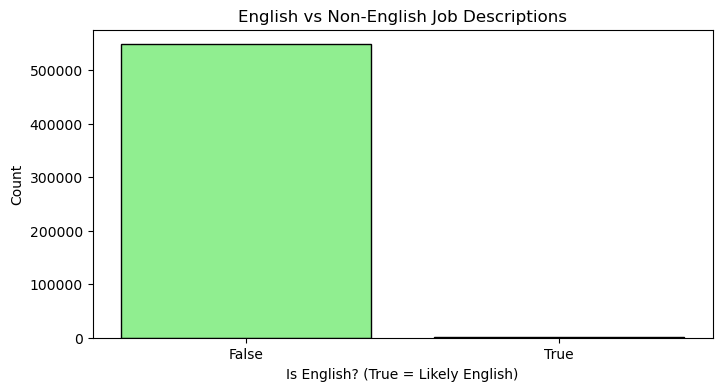

Minimum words: 1
Maximum words: 5699
Average words: 192.97057072366923
Subset of likely English job descriptions:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [56]:
# Set pandas option to display full text in columns
pd.set_option('display.max_colwidth', None)

# Define a basic function to check if a text is in English by matching some common English words.
def is_english(text, threshold=2):
    """
    Returns True if the input text contains at least 'threshold' number
    of common English words.
    """
    common_words = ['the', 'and', 'for', 'with', 'that', 'this', 'from']
    count = 0
    for word in common_words:
        if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE):
            count += 1
    return count >= threshold

# Ensure that every job description is a string.
df_job['description_full'] = df_job['description_full'].astype(str)

# Create a new column with the word count of each job description.
df_job['word_count'] = df_job['description_full'].apply(lambda x: len(x.split()))

# Create a new column that flags whether a job description is likely written in English.
df_job['is_english'] = df_job['description_full'].apply(lambda x: is_english(x))

# --- Visualization 1: Word Count Distribution ---
plt.figure(figsize=(10, 6))
plt.hist(df_job['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Job Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Visualization 2: English vs Non-English Job Descriptions ---
english_counts = df_job['is_english'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(english_counts.index.astype(str), english_counts.values, color='lightgreen', edgecolor='black')
plt.title('English vs Non-English Job Descriptions')
plt.xlabel('Is English? (True = Likely English)')
plt.ylabel('Count')
plt.show()

# Display basic statistics on word counts
print("Minimum words:", df_job['word_count'].min())
print("Maximum words:", df_job['word_count'].max())
print("Average words:", df_job['word_count'].mean())

# --- Subsetting: Extract Likely English Job Descriptions for Manual Review ---
df_english = df_job[df_job['is_english'] == True].copy()

# Optional: Display the first few rows of the filtered DataFrame for manual review.
print("Subset of likely English job descriptions:")
print(df_english[['description_full', 'word_count']].head())

In [75]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import unicodedata

# --- NLP & Preprocessing Libraries ---
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Télécharger les ressources NLTK nécessaires (si pas déjà fait)
nltk.download('punkt')
nltk.download('stopwords')

# --- Topic Modeling Libraries ---
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# --- (Optionnel) Visualisation avec pyLDAvis ---
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# ============================================================================
# STEP 0: ÉCHANTILLONNAGE ALÉATOIRE DE 200 ANNONCES
# ============================================================================

# df_job est le DataFrame complet avec une colonne "description_full"
df_sample = df_job.sample(n=200, random_state=42).copy()

# ============================================================================
# STEP 1: PRÉTRAITEMENT ENRICHI DES TEXTES (ANNONCES FRANÇAISES)
# ============================================================================

def preprocess_text(text, stop_words, remove_accents=False):
    """
    Prétraite le texte en :
      - Enlevant les balises HTML à l'aide de BeautifulSoup,
      - Enlevant d'éventuelles balises résiduelles via une regex,
      - Enlevant les URL,
      - Convertissant le texte en minuscules,
      - (Optionnel) Enlevant les accents,
      - Enlevant les caractères non alphabétiques (en gardant ou non les accents selon remove_accents),
      - Réduisant les espaces multiples,
      - Tokenisant le texte,
      - Enlevant les tokens de moins de 3 caractères,
      - Filtrant les stopwords français.
    """
    from bs4 import BeautifulSoup
    # Retirer les balises HTML
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")  # On joint le texte extrait avec des espaces

    # Supprimer d'éventuelles balises résiduelles
    text = re.sub(r'<[^>]+>', '', text)

    # Supprimer les URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Mettre en minuscules
    text = text.lower()
    
    # Optionnel : supprimer les accents
    if remove_accents:
        text = unicodedata.normalize('NFD', text)
        text = text.encode('ascii', 'ignore').decode('utf-8')
    
    # Conserver uniquement les lettres (si remove_accents True, seuls a-z sont gardés)
    if remove_accents:
        text = re.sub(r'[^a-z\s]', ' ', text)
    else:
        text = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ\s]', ' ', text)
    
    # Réduire les espaces multiples et nettoyer
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenisation
    tokens = word_tokenize(text, language="french")
    
    # Conserver uniquement les tokens de longueur > 2
    tokens = [token for token in tokens if len(token) > 2]
    
    # Filtrer les stopwords français
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

# Conversion de la colonne en chaîne et suppression des valeurs manquantes
df_sample['description_full'] = df_sample['description_full'].astype(str)
df_sample = df_sample.dropna(subset=['description_full'])

# Définition des stopwords français
french_stopwords = set(stopwords.words('french'))

# Appliquer le prétraitement.
# Pour supprimer les accents, passez remove_accents=True (sinon, False ou omis pour conserver les accents)
df_sample['tokens'] = df_sample['description_full'].apply(lambda x: preprocess_text(x, french_stopwords, remove_accents=True))

# Supprimer les lignes ne comportant aucun token
df_sample = df_sample[df_sample['tokens'].apply(lambda x: len(x) > 0)]

# ============================================================================
# STEP 2: GÉNÉRATION DES N-GRAMMES (BIGRAMMES ET TRIGRAMMES)
# ============================================================================

# Créer un modèle de bigrammes à partir des tokens
bigram = Phrases(df_sample['tokens'], min_count=5, threshold=10)
bigram_mod = Phraser(bigram)

# Créer un modèle de trigrammes basé sur la sortie du modèle de bigrammes
trigram = Phrases(bigram_mod[df_sample['tokens']], threshold=10)
trigram_mod = Phraser(trigram)

# Appliquer d'abord le modèle de bigrammes, puis le trigramme
df_sample['tokens_ngrams'] = df_sample['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# ============================================================================
# STEP 2.1: FILTRER POUR NE CONSERVER QUE LES BIGRAMMES/TRIGRAMMES
# ============================================================================

# On garde uniquement les tokens contenant un underscore ("_") qui indique des n-grammes fusionnés
df_sample['tokens_ngrammes_uniques'] = df_sample['tokens_ngrams'].apply(lambda doc: [token for token in doc if '_' in token])

# ============================================================================
# STEP 3: PRÉPARATION DU CORPUS POUR LDA
# ============================================================================

# Créer un dictionnaire Gensim à partir des tokens filtrés (n-grammes uniquement)
dictionary = corpora.Dictionary(df_sample['tokens_ngrammes_uniques'])

# Convertir les documents en sac de mots (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in df_sample['tokens_ngrammes_uniques']]

# Certains documents peuvent être vides après filtrage ; nous filtrons ces cas
df_sample = df_sample[[len(doc) > 0 for doc in df_sample['tokens_ngrammes_uniques']]]

# ============================================================================
# STEP 4: MODÉLISATION LDA AVEC 15 TOPICS
# ============================================================================

num_topics = 15

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=15,
    alpha='auto',
    per_word_topics=True
)

# Afficher les topics (ici 20 tokens par topic)
print("LDA Topics:\n")
for idx, topic in lda_model.print_topics(num_topics=-1, num_words=20):
    print(f"Topic {idx}:\n {topic}\n")


[nltk_data] Downloading package punkt to /Users/alfonso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alfonso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/5z/n4wfh12s55d5j381j6gl47c40000gn/T/ipykernel_74162/383126681.py:53: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


LDA Topics:

Topic 0:
 0.167*"prise_charge" + 0.122*"cabinet_recrutement" + 0.105*"bloc_operatoire" + 0.087*"faites_preuve" + 0.086*"force_proposition" + 0.035*"temps_plein" + 0.034*"prendre_charge" + 0.030*"rattache_directeur" + 0.023*"aujourd_hui" + 0.020*"moins_ans" + 0.020*"management_equipe" + 0.019*"mise_place" + 0.019*"mettre_place" + 0.019*"recherche_clients" + 0.019*"respect_regles" + 0.019*"issu_formation" + 0.019*"amelioration_continue" + 0.002*"egales_toutes" + 0.002*"candidatures_dont_celles_personnes" + 0.002*"cadre_politique"

Topic 1:
 0.127*"sein_equipe" + 0.083*"moins_ans" + 0.071*"description_poste" + 0.058*"description_profil" + 0.054*"consignes_securite" + 0.036*"suivi_activite" + 0.032*"justifiez_experience" + 0.032*"chef_equipe" + 0.030*"prise_charge" + 0.030*"profil_recherche" + 0.030*"relation_client" + 0.030*"experience_significative" + 0.030*"mise_place" + 0.030*"missions_principales" + 0.030*"transmettre_informations" + 0.030*"proposer_solutions" + 0.028*"fa

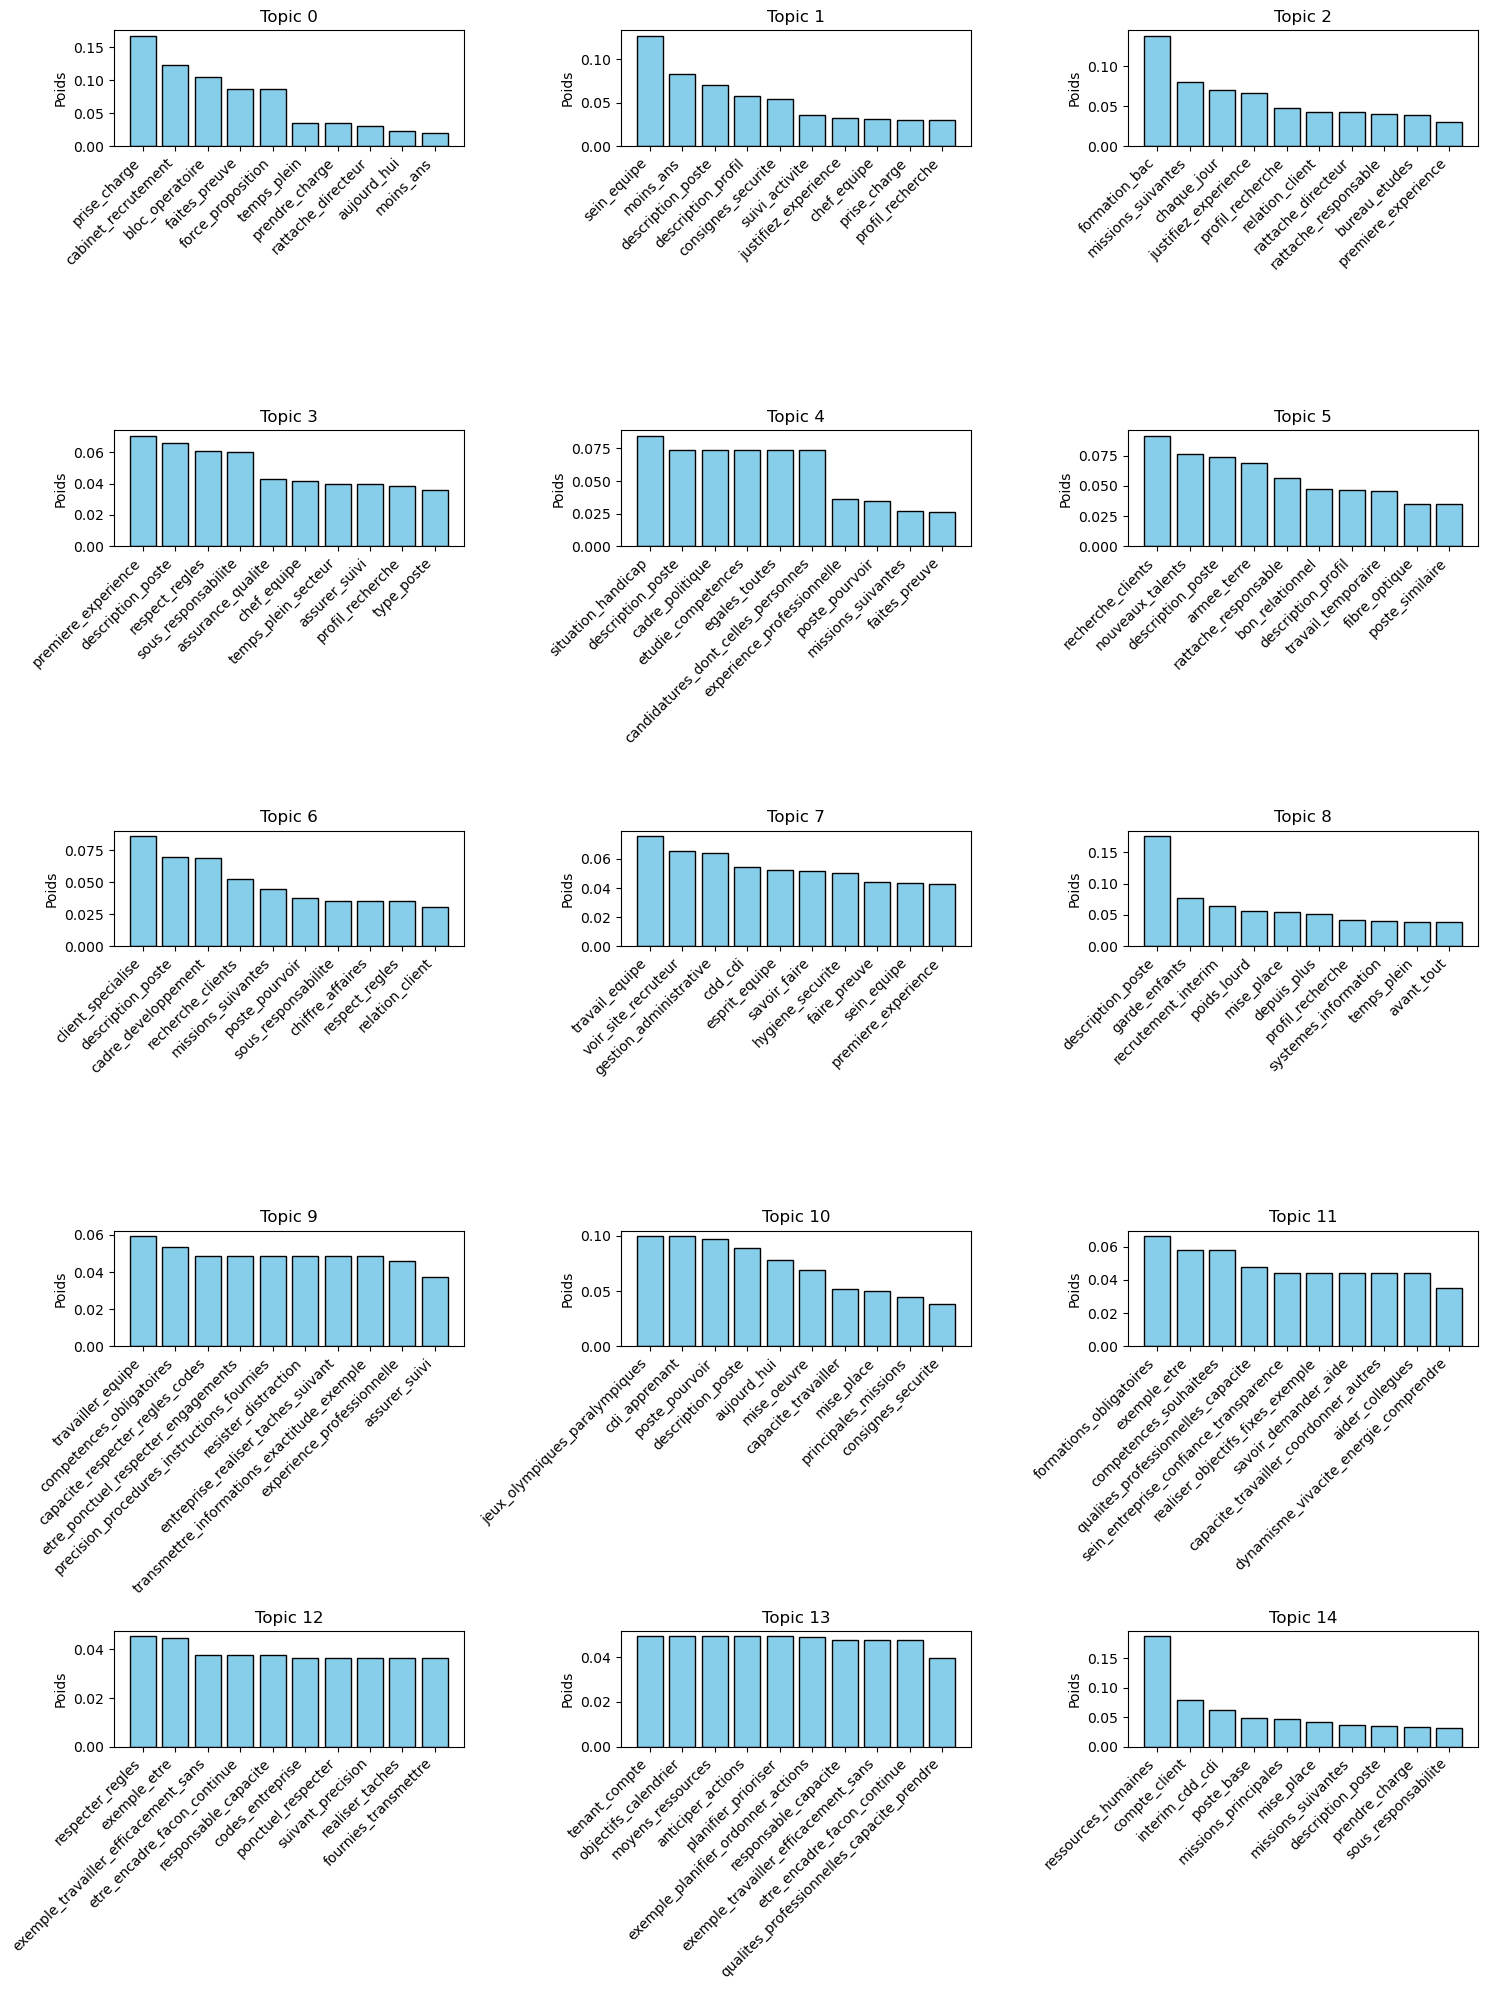

In [77]:
# ============================================================================
# (Optionnel) STEP 5: VISUALISATION ALTERNATIVE DES TOPICS AVEC DES BAR CHARTS
# ============================================================================

import math

n_topics = lda_model.num_topics
n_cols = 3
n_rows = math.ceil(n_topics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), squeeze=False)

for topic_num in range(n_topics):
    topic_terms = lda_model.get_topic_terms(topic_num, topn=10)
    words = [dictionary[id] for id, weight in topic_terms]
    weights = [weight for id, weight in topic_terms]
    
    ax = axes[topic_num // n_cols][topic_num % n_cols]
    ax.bar(range(len(words)), weights, color='skyblue', edgecolor='black')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=10)
    ax.set_title(f"Topic {topic_num}", fontsize=12)
    ax.set_ylabel("Poids", fontsize=10)

# Supprimer les axes vides s'il y en a de trop
for j in range(n_topics, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols][j % n_cols])
    
plt.tight_layout()
plt.show()
